# Figures for blog post

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(ggpattern, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## IB size vs frequency

![](ib-size-frequency.png)

In [2]:
blocks <- rbind(
    CJ(
        `Block rate [block/s]`=c(0.03, 0.3),
        `Block size [kB/block]`=40:180
    )[, .(
        `Block`="Leios IB",
        `Block rate [block/s]`,
        `Block size [kB/block]`,
        `Transaction rate [tx/s]`=1000*`Block rate [block/s]`*`Block size [kB/block]`/800
    )],
    CJ(
        `Block rate [block/s]`=10^(-50:50/50),
        `Block size [kB/block]`=40:180
    )[, .(
        `Block`="Leios IB",
        `Block rate [block/s]`,
        `Block size [kB/block]`,
        `Transaction rate [tx/s]`=1000*`Block rate [block/s]`*`Block size [kB/block]`/800
    )],
    data.table(
        `Block`="Praos",
        `Block rate [block/s]`=0.05, 
        `Block size [kB/block]`=88, 
        `Transaction rate [tx/s]`=5
    )
)
blocks %>% head

Block,Block rate [block/s],Block size [kB/block],Transaction rate [tx/s]
<chr>,<dbl>,<dbl>,<dbl>
Leios IB,0.03,40,1.5000
Leios IB,0.03,41,1.5375
Leios IB,0.03,42,1.5750
Leios IB,0.03,43,1.6125
Leios IB,0.03,44,1.6500
Leios IB,0.03,45,1.6875


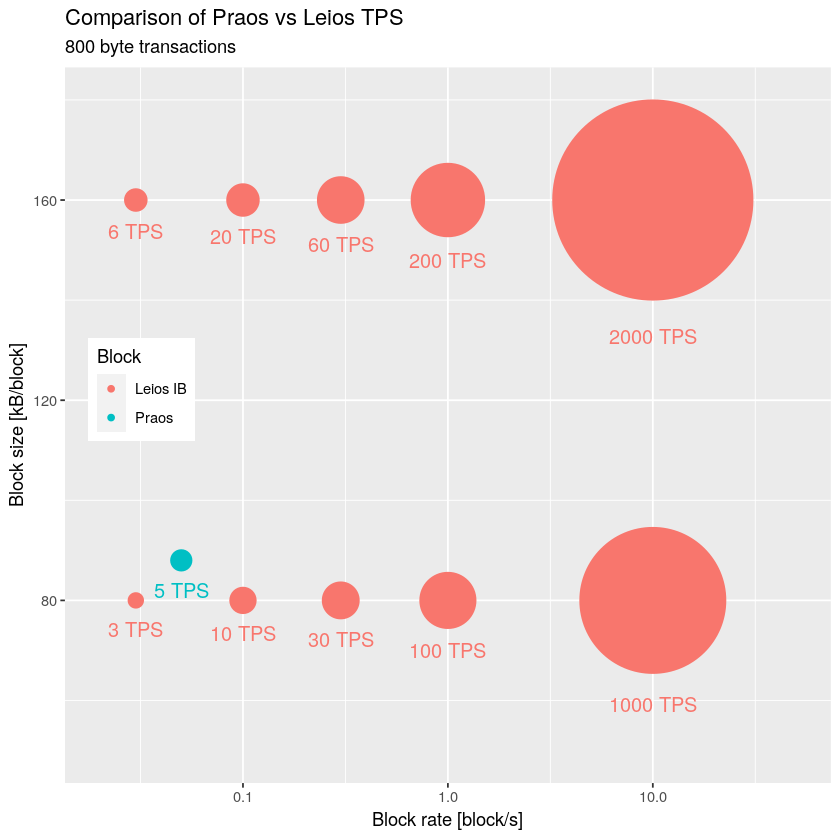

In [3]:
ggplot(
    blocks[`Block` == "Praos" | `Block rate [block/s]` %in% c(0.03, 0.1, 0.3, 1, 10) & `Block size [kB/block]` %in% c(80, 160)], 
    aes(x=`Block rate [block/s]`, y=`Block size [kB/block]`, size=`Transaction rate [tx/s]`, color=`Block`)
) +
    geom_point() +
    geom_text(aes(y=`Block size [kB/block]`-5-1*sqrt(`Transaction rate [tx/s]`)/2, label=paste(`Transaction rate [tx/s]`, "TPS")), size=NA) +
    scale_x_log10(lim=c(0.02, 50)) +
    scale_y_continuous(lim=c(50, 180)) +
    scale_size_continuous(range = 1.25*sqrt(c(10, 2000)), guide = "none") +
    theme(legend.position=c(0.10, 0.55)) +
    ggtitle("Comparison of Praos vs Leios TPS", subtitle="800 byte transactions")

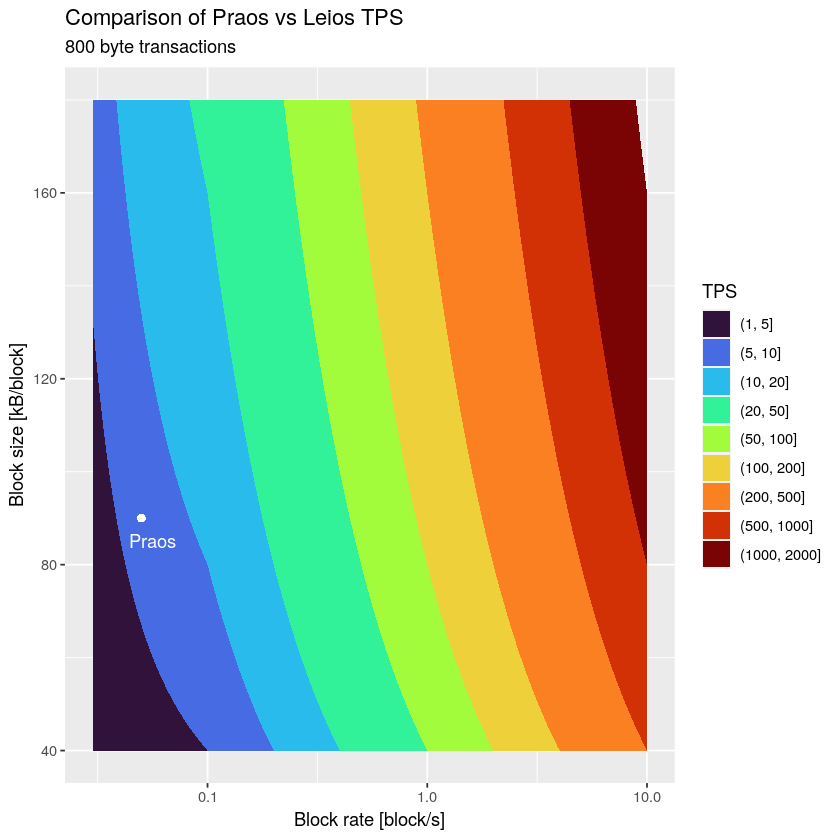

In [4]:
ggplot(
    blocks[`Block` == "Leios IB"], 
    aes(x=`Block rate [block/s]`, y=`Block size [kB/block]`, z=`Transaction rate [tx/s]`)
) +
    geom_contour_filled(breaks=c(1,5,10,20,50,100,200,500,1000,2000)) +
    geom_point(aes(x=0.05,y=90), color="white") +
    geom_text(data=data.table(`Block rate [block/s]`=0.05,`Block size [kB/block]`=90,`Transaction rate [tx/s]`=5), color="white", label="Praos", nudge_x=0.05, nudge_y=-5) +
    scale_x_log10() +
    scale_fill_viridis_d(option = "turbo") +
    guides(fill=guide_legend(title="TPS")) +
    ggtitle("Comparison of Praos vs Leios TPS", subtitle="800 byte transactions")

In [5]:
ggsave("block-praos-leios-contour.png", units="in", dpi=150, width=8, height=6)

In [6]:
ggsave("block-praos-leios-contour.svg", units="in", dpi=150, width=8, height=6)

## Time vs throughput

![](time-throughput.png)

### Computation of delays in stages

#### Stage 1. `Propose`

Once a transaction reaches the memory pool, it waits for an IB that matches its shard constraint.

- IB production rate: $f_\text{IB}$
- Number of shards: $n_\text{shard}$
- IB production rate per shard: $f^*_\text{IB} = f_\text{IB} / n_\text{shard}$
- IB shard probability: $f^\prime_\text{IB} = 1 - e^{- f_\text{IB} / n_\text{shard}}$
- Number of slots from submitting a transaction to having it appear in an IB: $\mathbf{S_1}$
- Probability density: $p_1(s_1) := \mathcal{P}[\mathbf{S_1} = s_1] = b(s_1, f^\prime_\text{IB})$

In [7]:
p1 <- function(s, f) {
    p <- 1 - exp(-f)
    dnbinom(s, 1, p)
}

#### Stage 2. `Deliver1`

The transaction reaches the beginning of `Deliver1` according to a uniform distribution.

- Stage length: $L$
- Duration of `Deliver1` stage: $L$
- Number of slots from when the IB was produced to the start of Delivery1: $\mathbf{S_2}$
- Probability density: $p_2(s_2) := \mathcal{P}[\mathbf{S_2} = s_2] = 1 / L$

In [8]:
p2 <- function(s, f, L) {
    1 / L
}

#### Stage 3. `Deliver2`

The `Deliver2` stage lasts $L$ slots.

#### Stage 4. `Endorse`

If the IB is not included in an EB at the `Endorse` stage, it is orphaned forever.

- EB production rate: $f_\text{EB}$
- EB production probability: $f^\prime_\text{EB} = 1 - e^{- f_\text{EB}}$
- Whether the IB is linked to an EB: $\mathbf{S_4}$.
- Probability: $p_4(s_4) := \mathcal{P}[\mathbf{S_4} = s_4]$
    - $p_4(1) = f^\prime_\text{EB}$
    - $p_4(0) = 1 - f^\prime_\text{EB}$

In [9]:
p4 <- function(s, f) {
    p <- 1 - exp(- f)
    if (s == 0)
        1 - p
    else
        p
}

### Stage 5. `Vote(Send)`

The `Vote1` stage lasts $L$ slots.

### Stage 6. `Vote(Receive)`

In Full Short Leios, the EB waits for a pipeline where it is endorsed. If it is not endorsed in current pipeline, it has to skip two pipelines before it is included in a later endorsement stage.

- Number of stages before IB is endorsed: $\mathbf{S_6}$
- Probability: $p_6(s_6) := \mathcal{P}[\mathbf{S_6} = s_6]$
    - $p_6(0) = f^\prime_\text{EB}$
    - $p_6(1) = 0$
    - $p_6(2) = 0$
    - $p_6(s_6) = b(s_6 - 2, f^\prime_\text{EB})$, for $s > 2$

In [10]:
p6 <- function(s, f) {
    p <- 1 - exp(-f)
    if (s == 0)
        dnbinom(0, 1, p)
    else if (s == 1 || s == 2)
        0
    else
        dnbinom(s - 2, 1, p)
}  

### Praos

Now wait for a Praos block.

- Active slot coefficient: $f_\text{RB} = 0.05$
- Number of slots to wait for inclusion in an RB: $\mathbf{S_\text{RB}}$
- Probability density: $p_\text{RB}(s_\text{RB}) := \mathcal{P}[\mathbf{S_\text{RB}} = s_\text{RB}] = b(s_\text{RB}, 1, f_\text{RB})$

In [11]:
pRB <- function(s, f) 
    dnbinom(s, 1, f)

## Distribution of waiting times

- Slots from transaction submission to its referencing in an RB: $\mathbf{T}$
    - $\mathbf{S_4} = 1 \implies \mathbf{T} = \mathbf{S_1} + \mathbf{S_2} + L + L + L + L + (\mathbf{S_6} + 1) L + \mathbf{S_\text{RB}} = \mathbf{S_1} + \mathbf{S_2} + (5 + \mathbf{S_6}) L + \mathbf{S_\text{RB}}$
    - $\mathbf{S_4} = 0 \implies \mathbf{T} = \infty$
- Joint probability density: $p_T(s_1, s_2, s_4, s_6, s_\text{RB}, L, f^*_\text{IB}, f_\text{EB}, f_\text{RB}, L) = p_1(s_1, f^*_\text{IB}) \cdot p_2(s_2, f^*_\text{IB}, L) \cdot p_4(s_4, f_\text{EB}) \cdot p_6(s_6, f_\text{EB}) \cdot p_\text{RB}(s_\text{RB}, f_\text{RB})$

Because the joint probability distribution is the product of terms to variable powers, it might be feasible to evaluate the sums involved in computing the distribution of $\mathbf{T}$. For now, we'll just tabulate the result and sum numerically.

In [12]:
pttab <- function(fIB, fEB, fRB, L, mu=1, lambda=1) {
    acc <- 10
    tab1 <- data.table(`s1`=0:ceiling(acc/(1-exp(-fIB))))[, .(`DMY`=TRUE, `s1`, `p1`=mapply(p1, `s1`, fIB))]
    tab2 <- data.table(`s2`=1:L)[, .(`DMY`=TRUE, `s2`, `p2`=mapply(p2, `s2`, fIB, L))]
    tab4 <- data.table(`s4`=0:1)[, .(`DMY`=TRUE, `s4`, `p4`=mapply(p4, `s4`, fEB))]
    tab6 <- data.table(`s6`=0:ceiling(acc/(1-exp(-fEB))))[, .(`DMY`=TRUE, `s6`, `p6`=mapply(p6, `s6`, fEB))]
    tabRB <- data.table(`sRB`=0:ceiling(acc/fRB))[, .(`DMY`=TRUE, `sRB`, `pRB`=mapply(pRB, `sRB`, fRB))]
    z <- tab1[tab2, on=.(`DMY`), allow.cartesian=TRUE][, .(`DMY`=TRUE, `p`=sum(`p1`*`p2`)), .(`T`=`s1`+`s2`)]
    z <- tab6[z, on=.(`DMY`), allow.cartesian=TRUE][, .(`DMY`=TRUE, `p`=sum(`p`*`p6`)), .(`T`=`T`+(5+`s6`)*L)]
    z <- tabRB[z, on=.(`DMY`), allow.cartesian=TRUE][, .(`DMY`=TRUE, `p`=sum(`p`*`pRB`)), .(`T`=`T`+`sRB`)]
    tab4[z, on=.(`DMY`), allow.cartesian=TRUE][, .(`p`=sum(`p`*`p4`)), .(`T`=`T`/`s4`)]
}

#### Check that probability is conserved.

In [13]:
pttab(0.1, 1.5, 0.05, 20)[, sum(`p`)]

[1] 0.9999441

#### Plot some examples

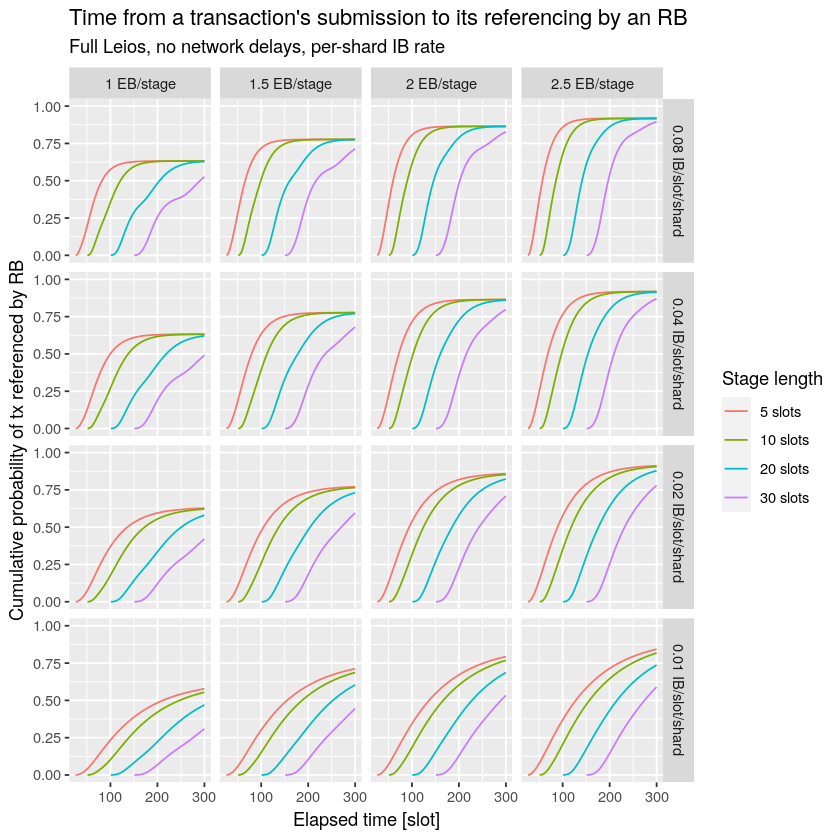

In [14]:
ggplot(
    CJ(`fIB`=c(0.01, 0.02, 0.04, 0.08), `fEB`=c(1.0, 1.5, 2.0, 2.5), `fRB`=0.05, `L`=c(5, 10, 20, 30))[,
        as.list(mapply(pttab, `fIB`, `fEB`, `fRB`, `L`)),
        by=.(`fIB`, `fEB`, `fRB`, `L`),
    ][order(`fIB`, `fEB`, `fRB`, `L`, `V1`)][
        !is.infinite(`V1`) & `V1` <= 300, 
        .(`T`=`V1`, `p`=cumsum(`V2`)), 
        .(
            `fIB`=factor(paste(`fIB`, "IB/slot/shard"), levels=c("0.08 IB/slot/shard", "0.04 IB/slot/shard", "0.02 IB/slot/shard", "0.01 IB/slot/shard")),
            `fEB`=paste(factor(`fEB`), "EB/stage"), 
            `fRB`, 
            `Stage length`=factor(paste(`L`, "slots"), levels=c("5 slots", "10 slots", "20 slots", "30 slots"))
        )
    ], 
    aes(x=`T`, y=`p`, color=`Stage length`)
) +
    geom_line() +
    ylim(0, 1) +
    facet_grid(`fIB` ~ `fEB`) +
    xlab("Elapsed time [slot]") +
    ylab("Cumulative probability of tx referenced by RB") +
    ggtitle(
        "Time from a transaction's submission to its referencing by an RB", 
        subtitle="Full Leios, no network delays, per-shard IB rate"
    )

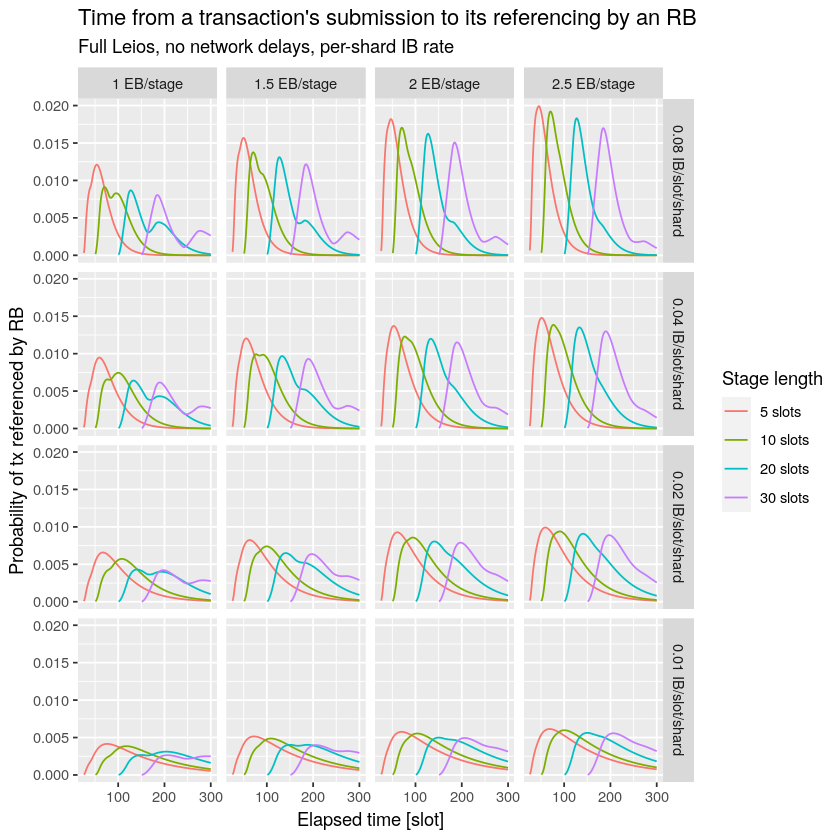

In [15]:
ggplot(
    CJ(`fIB`=c(0.01, 0.02, 0.04, 0.08), `fEB`=c(1.0, 1.5, 2.0, 2.5), `fRB`=0.05, `L`=c(5, 10, 20, 30))[,
        as.list(mapply(pttab, `fIB`, `fEB`, `fRB`, `L`)),
        by=.(`fIB`, `fEB`, `fRB`, `L`),
    ][order(`fIB`, `fEB`, `fRB`, `L`, `V1`)][
        !is.infinite(`V1`) & `V1` <= 300, 
        .(`T`=`V1`, `p`=`V2`), 
        .(
            `fIB`=factor(paste(`fIB`, "IB/slot/shard"), levels=c("0.08 IB/slot/shard", "0.04 IB/slot/shard", "0.02 IB/slot/shard", "0.01 IB/slot/shard")),
            `fEB`=paste(factor(`fEB`), "EB/stage"), 
            `fRB`, 
            `Stage length`=factor(paste(`L`, "slots"), levels=c("5 slots", "10 slots", "20 slots", "30 slots"))
        )
    ], 
    aes(x=`T`, y=`p`, color=`Stage length`)
) +
    geom_line() +
    #ylim(0, 1) +
    facet_grid(`fIB` ~ `fEB`) +
    xlab("Elapsed time [slot]") +
    ylab("Probability of tx referenced by RB") +
    ggtitle(
        "Time from a transaction's submission to its referencing by an RB", 
        subtitle="Full Leios, no network delays, per-shard IB rate"
    )

In [16]:
Delta <- 5  #  [s]
delta <- 2  #  [IB/shard]
shards <- function(ibRate)
    ceiling(ibRate * Delta / delta)
ibShardRate <- function(ibRate)
    ibRate / shards(ibRate)

In [17]:
data.table(`IB/s`=c(0.05,0.1,0.5,1,5,10))[, .(`IB/s`, `IB/s/shard`=mapply(ibShardRate,`IB/s`))]

IB/s,IB/s/shard
<dbl>,<dbl>
0.05,0.0500000
0.10,0.1000000
0.50,0.2500000
1.00,0.3333333
5.00,0.3846154
10.00,0.4000000


In [18]:
pttab1 <- function(fIB, fEB, fRB, L) {
    if (fIB == 0.05) {
        # Praos
        data.table(`T`=as.numeric(1:300), `p`=mapply(pRB, 1:300, fRB))
    } else {
        # Leios
        pttab(fIB, fEB, fRB, L)
    }
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1050 rows containing missing values (`geom_line()`).”


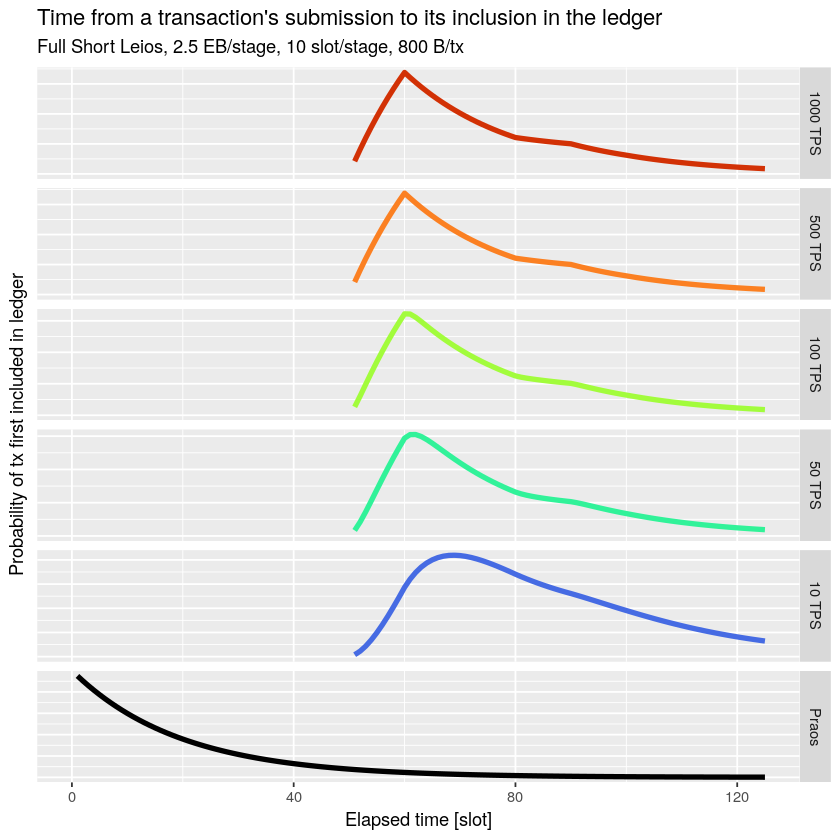

In [19]:
ggplot(
    CJ(`fIB`=c(0.05,0.1,0.5,1,5,10), `fEB`=2.5, `fRB`=0.05, `L`=10)[,
        as.list(mapply(pttab1, `fIB`, `fEB`, `fRB`, `L`)),
        by=.(`fIB`, `fEB`, `fRB`, `L`),
    ][order(`fIB`, `fEB`, `fRB`, `L`, `V1`)][
        !is.infinite(`V1`) & `V1` <= 300, 
        .(`T`=`V1`, `p`=`V2`), 
        .(
            `fIB`=factor(ifelse(`fIB`==0.05, "Praos", paste(1000*80/800*`fIB`, "TPS")), levels=c("1000 TPS", "500 TPS", "100 TPS", "50 TPS", "10 TPS", "Praos")),
            `fEB`=paste(factor(`fEB`), "EB/stage"), 
            `fRB`, 
            `Stage length`=factor(paste(`L`, "slots"), levels=c("5 slots", "10 slots", "20 slots", "30 slots"))
        )
    ], 
    aes(x=`T`, y=`p`, color=`fIB`)
) +
    geom_line(size=1.5) +
    facet_grid(`fIB` ~ ., scales="free") +
    scale_color_manual(values=c(
        "Praos"="black", 
        "10 TPS"="#466be3",
        "50 TPS"="#31f299",
        "100 TPS"="#a2fc3c",
        "500 TPS"="#fb8022",
        "1000 TPS"="#d23105"
    )) +
    xlim(0, 125) +
    xlab("Elapsed time [slot]") +
    ylab("Probability of tx first included in ledger") +
    ggtitle(
        "Time from a transaction's submission to its inclusion in the ledger", 
        subtitle="Full Short Leios, 2.5 EB/stage, 10 slot/stage, 800 B/tx"
    ) +
    theme(axis.text.y=element_blank(), axis.ticks.y = element_blank(), legend.position="none")

In [20]:
ggsave("tx-to-block-fig.png", units="in", dpi=150, width=8, height=6)

Warning message:
“Removed 1050 rows containing missing values (`geom_line()`).”


In [21]:
ggsave("tx-to-block-fig.svg", units="in", dpi=150, width=8, height=6)

Warning message:
“Removed 1050 rows containing missing values (`geom_line()`).”


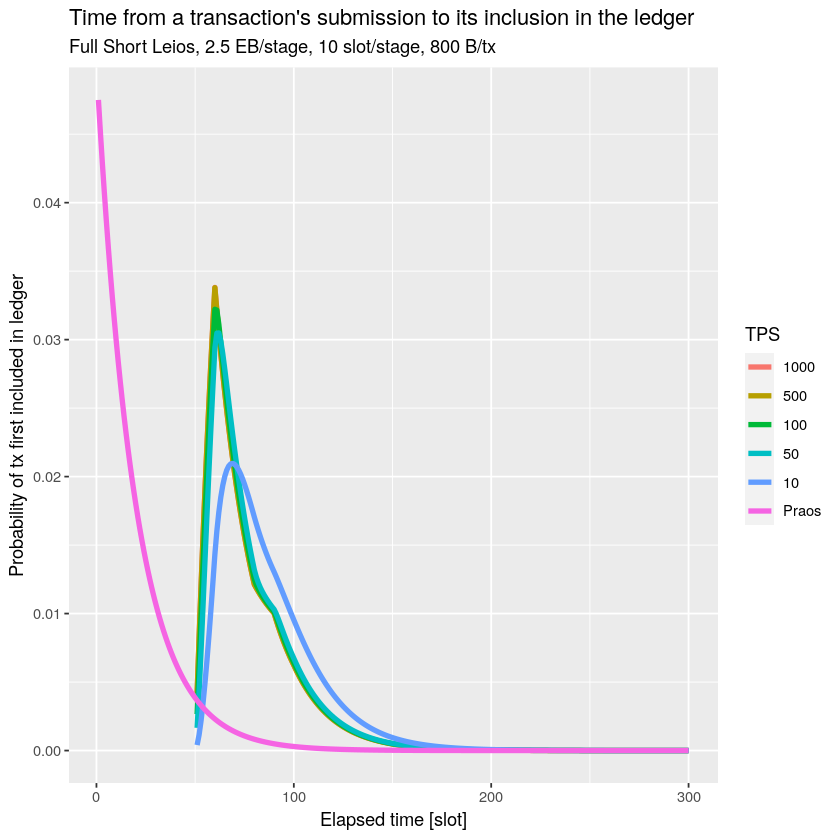

In [22]:
ggplot(
    CJ(`fIB`=c(0.05,0.1,0.5,1,5,10), `fEB`=2.5, `fRB`=0.05, `L`=10)[,
        as.list(mapply(pttab1, `fIB`, `fEB`, `fRB`, `L`)),
        by=.(`fIB`, `fEB`, `fRB`, `L`),
    ][order(`fIB`, `fEB`, `fRB`, `L`, `V1`)][
        !is.infinite(`V1`) & `V1` <= 300, 
        .(`T`=`V1`, `p`=`V2`), 
        .(
            `fIB`=factor(ifelse(`fIB`==0.05, "Praos", 1000*80/800*`fIB`), levels=c("1000", "500", "100", "50", "10", "Praos")),
            `fEB`=paste(factor(`fEB`), "EB/stage"), 
            `fRB`, 
            `Stage length`=factor(paste(`L`, "slots"), levels=c("5 slots", "10 slots", "20 slots", "30 slots"))
        )
    ], 
    aes(x=`T`, y=`p`, color=`fIB`)
) +
    geom_line(size=1.5) +
    xlab("Elapsed time [slot]") +
    ylab("Probability of tx first included in ledger") +
    guides(color=guide_legend(title="TPS")) +
    ggtitle(
        "Time from a transaction's submission to its inclusion in the ledger", 
        subtitle="Full Short Leios, 2.5 EB/stage, 10 slot/stage, 800 B/tx"
    )